[![Open In Colab](https://img.shields.io/static/v1?message=Open%20in%20Colab&logo=googlecolab&label=%20&labelColor=5c5c5c&color=23c7a2&style=flat-square)](https://colab.research.google.com/github/einbandi/paradime/blob/master/notebooks/mds.ipynb)

In [1]:
import sys
sys.path.append("../../")

import numpy as np
import torch
import sklearn.datasets
import sklearn.decomposition
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

import paradime.dr
import paradime.relations
import paradime.transforms
import paradime.loss
import paradime.utils

paradime.utils.seed.seed_all(42);

In [5]:
diabetes = sklearn.datasets.load_diabetes()
data = diabetes['data']

In [6]:
def mse(a, b):
    return torch.sum((a - b) ** 2)

In [7]:
def normalized_stress(a, b):
    return torch.sum((a - b) ** 2) / torch.sum(a ** 2)

In [4]:
df = pd.DataFrame()

hd_pdist = torch.nn.functional.pdist(torch.tensor(data))

In [38]:
len(data)

442

In [33]:
for name, model in zip(
    ["Linear (10, 2)", "Non-linear (10, 2)", "Non-linear (10, 5, 2)"],
    [
        torch.nn.Linear(10, 2, bias=False),
        torch.nn.Sequential(
            torch.nn.Linear(10, 2, bias=True),
            torch.nn.Softplus(),
        ),
        torch.nn.Sequential(
            torch.nn.Linear(10, 5, bias=True),
            torch.nn.Softplus(),
            torch.nn.Linear(5, 2, bias=True),
            torch.nn.Softplus(),
        ),
    ],
):
    for bs in [10, 50, 100, 221, 442]
    for _ in range(10):

        pd_mds = paradime.dr.ParametricDR(
            model=model,
            global_relations=paradime.relations.PDist(
                transform=[
                    paradime.transforms.ToSquareTensor(),
                    # paradime.transforms.Functional(lambda x: x.float()),
                ]
            ),
            batch_relations=paradime.relations.DifferentiablePDist(
                transform=paradime.transforms.ToSquareTensor()
            ),
            dataset=data,
            verbose=True,
        )
        pd_mds.add_training_phase(
            epochs=500,
            batch_size=len(data) // 5,
            learning_rate=0.02,
            loss=paradime.loss.RelationLoss(
                loss_function=mse,
                embedding_method="forward",
                normalize_sub=False,
            ),
            report_interval=75,
        )
        pd_mds.train()

        curr_losses.append(
            mse(
                hd_pdist,
                torch.nn.functional.pdist(pd_mds.apply(data)),
            )
        )
        curr_embs.append(pd_mds.apply(data))

    losses[name] = torch.stack(curr_losses)
    embeddings[name] = torch.stack(curr_embs)


2022-09-11 15:13:11,499: Registering dataset.
2022-09-11 15:13:11,500: Computing global relations 'rel'.
2022-09-11 15:13:11,501: Calculating pairwise distances.
2022-09-11 15:13:11,503: Beginning training phase 'None'.
2022-09-11 15:13:11,511: Loss after epoch 0: 763.5264456293099
2022-09-11 15:13:12,038: Loss after epoch 75: 124.78395673812157
2022-09-11 15:13:12,609: Loss after epoch 150: 121.12906690927885
2022-09-11 15:13:13,143: Loss after epoch 225: 119.85574532329855
2022-09-11 15:13:13,675: Loss after epoch 300: 123.81377377704665
2022-09-11 15:13:14,203: Loss after epoch 375: 122.38660393807707
2022-09-11 15:13:14,727: Loss after epoch 450: 120.99419651624267
2022-09-11 15:13:15,071: Registering dataset.
2022-09-11 15:13:15,072: Computing global relations 'rel'.
2022-09-11 15:13:15,072: Calculating pairwise distances.
2022-09-11 15:13:15,075: Beginning training phase 'None'.
2022-09-11 15:13:15,083: Loss after epoch 0: 123.6466479860151
2022-09-11 15:13:15,614: Loss after epo

In [9]:
class DirectModel(torch.nn.Module):
    def __init__(self, size, dim):
        super().__init__()
        self.coords = torch.nn.Linear(size, dim, bias=False)

    def forward(self, X):
        pass

    def embed(self, indices):
        return self.coords.weight.data[indices]


class DirectLoss(paradime.loss.Loss):
    def forward(
        self,
        model,
        global_relations,
        batch_relations,
        batch,
        device,
    ) -> torch.Tensor:
        global_rel = global_relations["rel"].sub(batch["indices"])
        batch_rel = (
            batch_relations["rel"]
            .compute_relations(model.coords.weight[batch["indices"]])
            .data
        )

        return mse(global_rel, batch_rel)

direct_losses = []
direct_embs = []
for _ in range(10):

    pd_mds = paradime.dr.ParametricDR(
        model=DirectModel(2, len(data)),
        global_relations=paradime.relations.PDist(
            transform=[
                paradime.transforms.ToSquareTensor(),
                # paradime.transforms.Functional(lambda x: x.float()),
            ]
        ),
        batch_relations=paradime.relations.DifferentiablePDist(
            transform=paradime.transforms.ToSquareTensor()
        ),
        dataset=data,
        verbose=True,
    )
    pd_mds.add_training_phase(
        epochs=500,
        batch_size=len(data)//5,
        learning_rate=0.01,
        loss=DirectLoss(),
        report_interval=75,
    )
    pd_mds.train()

    direct_losses.append(
         mse(
            hd_pdist,
            torch.nn.functional.pdist(pd_mds.model.coords.weight.data),
        )
    )
    direct_embs.append(pd_mds.model.coords.weight.data)

losses["direct"] = torch.stack(direct_losses)
embeddings["direct"] = torch.stack(direct_embs)


2022-09-11 14:56:49,372: Registering dataset.
2022-09-11 14:56:49,373: Computing global relations 'rel'.
2022-09-11 14:56:49,373: Calculating pairwise distances.
2022-09-11 14:56:49,375: Beginning training phase 'None'.
2022-09-11 14:56:49,383: Loss after epoch 0: 17051.57448421094
2022-09-11 14:56:49,923: Loss after epoch 75: 205.6027512085764
2022-09-11 14:56:50,448: Loss after epoch 150: 126.09358552410336
2022-09-11 14:56:50,969: Loss after epoch 225: 108.8191870381525
2022-09-11 14:56:51,492: Loss after epoch 300: 106.12731148315645
2022-09-11 14:56:52,031: Loss after epoch 375: 104.71601032104721
2022-09-11 14:56:52,564: Loss after epoch 450: 104.82924961631898
2022-09-11 14:56:52,913: Registering dataset.
2022-09-11 14:56:52,914: Computing global relations 'rel'.
2022-09-11 14:56:52,914: Calculating pairwise distances.
2022-09-11 14:56:52,916: Beginning training phase 'None'.
2022-09-11 14:56:52,924: Loss after epoch 0: 15132.396826835802
2022-09-11 14:56:53,455: Loss after epoc

In [5]:
from sklearn.manifold import MDS

sklearn_losses = []
sklearn_embs = []
for _ in range(10):
    mds = torch.tensor(MDS().fit_transform(data))
    sklearn_losses.append(mse(
        hd_pdist,
        torch.nn.functional.pdist(mds)
    ))
    sklearn_embs.append(mds)

losses["sklearn"] = torch.stack(sklearn_losses)
embeddings["sklearn"] = torch.stack(sklearn_embs)

In [41]:
baz = pd.DataFrame(columns=["a", "b"])

pd.DataFrame([[1., "foo"]], columns=["a", "b"])

,a,b
0,1.0,foo


In [34]:
df = pd.DataFrame.from_dict({
    "Model": np.repeat(list(losses.keys()), [len(i) for i in losses.values()]),
    "Loss": torch.cat(list(losses.values()))
})

(0.0, 320.0)

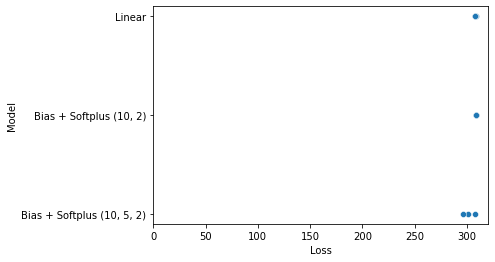

In [35]:
fig, ax = plt.subplots()
sns.scatterplot(data=df, x="Loss", y="Model", ax=ax)
ax.set_xlim(0, 320)

In [51]:


df = pd.DataFrame()
for l, n in zip(
    torch.tensor(losses).tolist(), ["linear", "bias + relu", "(10, 10, 2)"]
):
    df[n] = l
df["direct"] = torch.tensor(direct_losses).tolist()
df["sklearn"] = torch.tensor(sklearn_losses).tolist()

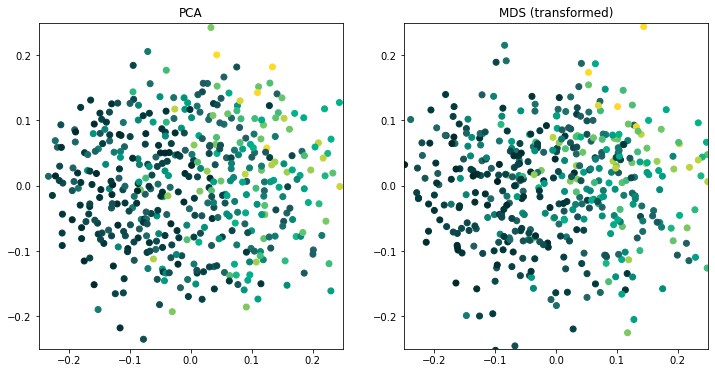

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(
    # *np.stack([np.dot(pca.components_[:2], i) for i in data]).T,
    *(sklearn.decomposition.PCA().fit_transform(xx)).T,
    c=diabetes.target,
    cmap=cmap,
)
ax1.set_xlim(-0.25, 0.25)
ax1.set_ylim(-0.25, 0.25)
ax1.set_title("PCA")
ax2.scatter(
    *(sklearn.decomposition.PCA().fit_transform(pd_mds.apply(data))).T,
    c=diabetes.target,
    cmap=cmap,
)
ax2.set_xlim(-0.25, 0.25)
ax2.set_ylim(-0.25, 0.25)
ax2.set_title("MDS (transformed)");

In [8]:
df = pd.read_csv("mds_runs.csv")

In [9]:
cmap = paradime.utils.plotting.get_colormap()

In [16]:
import scipy.spatial.distance
dists = scipy.spatial.distance.pdist(data)

In [17]:
np.sum(dists ** 2)

4420.000000000001

In [20]:
import sklearn.manifold
standard_mds = sklearn.manifold.MDS().fit_transform(data)

In [23]:
mse(torch.tensor(scipy.spatial.distance.pdist(standard_mds)), torch.tensor(dists)) / np.sum(dists ** 2)

tensor(0.0580, dtype=torch.float64)

In [24]:
df["NormLoss"] = df["Loss"] / np.sum(dists ** 2)

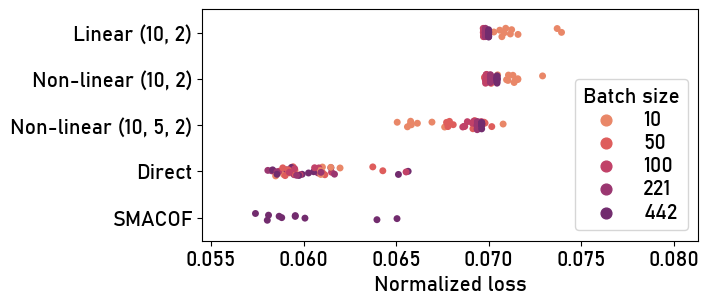

In [45]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Bahnschrift"]
plt.rcParams["font.size"] = 15
plt.rcParams["legend.labelspacing"] = 0.2

fig, ax = plt.subplots()
sns.stripplot(
    data=df,
    # x="Loss",
    x="NormLoss",
    y="Model",
    hue="Batch size",
    dodge=False,
    ax=ax,
    palette="flare",
)
# ax.set_xlim(240, 360)
ax.set_xlim(0.95 * df["NormLoss"].min(), 1.1 * df["NormLoss"].max())
ax.set_aspect(0.0025)
ax.set_xlabel("Normalized loss")
ax.set_ylabel("")
sns.move_legend(ax, "lower right")

fig.savefig("mds-stats.pdf", bbox_inches = "tight")

In [33]:
df["Loss"][np.logical_and(
    df["Model"] == "Non-linear (10, 5, 2)",
    df["Batch size"] < 50
)].mean()

295.55839000000003

In [29]:
df["NormLoss"].min()

0.057398280542986416

In [34]:
295.5583 / 264.8535

1.1159312601117222